In [ ]:
library(ape)
library(ggplot2)
library(dplyr)
library(tidyr)

In [9]:
taxtest <- tax_id("/hps/nobackup/rdf/metagenomics/research-team/escameron/lichen_proteins/lichen_bacteria_gtbk.csv", tax_level = "5")

In [2]:
tax_id <- function(dirpath, tax_level = c(1,2,3,4,5,6,7)){
    tax_level <- match.arg(tax_level)
    taxonomy <- read.csv(dirpath, sep =",")
    for (i in 1:nrow(taxonomy)){
        tax_id <- stringr::str_split(taxonomy$classification, ";")[[i]][tax_level]
        taxonomy$classification[i] <- substring(tax_id, 4, nchar(tax_id))
        }
    colnames(taxonomy) <- c("sample", "tax_classification")
    taxonomy
    }
                   
files_from_folder <- function(dirpath){
    filenames <- list.files(path = dirpath)
    listlength <- length(filenames)
    seq_list <- vector("list", listlength)
    for (i in 1:listlength){
        sample <- filenames[i]
        seq_path <- paste(dirpath, sample, "/", sample, ".gbk.emerald/", sample, ".gbk.emerald.full.gff",sep = "")
            if (file.exists(seq_path)) {
                if (file.size(seq_path) > 16) {
                    seq_input <- read.gff(seq_path)
                    } else {
                    seq_input <- data.frame(seqid = "N/A", source = "N/A", type = "N/A", start = "N/A", end = "N/A", score = "N/A", strand = "N/A", phase = "N/A", attributes = "N/A")
                    }
                }
        seq_list[[i]] <- seq_input
    }
    
    names(seq_list) <- filenames
    for (i in seq_along(seq_list)) seq_list[[i]]$sample <- filenames[i]
    bgc <- Reduce(rbind, seq_list)
    
    bgc <- bgc %>% separate(attributes, c("cluster_id", "nearest_mibig", "mibig_class", "jaccard", "partial_cluster"), sep = ";")
    
    for (i in 1:nrow(bgc)){
        for (j in 9:13){
            bgc[i,j] <- gsub(".*=", "", bgc[i,j])
            }
        }
    bgc
}

In [7]:
emeraldbgc <- files_from_folder("/hps/nobackup/rdf/metagenomics/research-team/escameron/lichen_proteins/emeraldbgc/")

Warning message:
“Expected 5 pieces. Missing pieces filled with `NA` in 4 rows [666, 3340, 4273, 5957].”


In [10]:
emeraldbgc_tax <- merge(emeraldbgc, taxtest)

In [19]:
emeraldbgc_mibig <- data.frame(nearest_mibig = unique(emeraldbgc_tax$nearest_mibig), product = rep(" ", length(unique(emeraldbgc_tax$nearest_mibig))))
write.csv(emeraldbgc_mibig, "/hps/nobackup/rdf/metagenomics/research-team/escameron/lichen_proteins/emeraldbgc_lichens.csv")

In [20]:
emeraldbgc_mibigprod <- read.csv("/hps/nobackup/rdf/metagenomics/research-team/escameron/lichen_proteins/emeraldbgc_lichens.csv")

In [26]:
emeraldbgc_prod <- merge(emeraldbgc_tax, emeraldbgc_mibigprod)

In [27]:
gulnara_mag <- read.csv("/hps/nobackup/rdf/metagenomics/research-team/escameron/lichen_proteins/mag_table_annotated.txt", sep = "")
mag_id <- gulnara_mag$mag

In [43]:
subset_emerald <- emeraldbgc_prod[emeraldbgc_prod$sample %in% mag_id,]

In [29]:
unique(subset_emerald$mibig_class)
length(unique(subset_emerald$nearest_mibig))

[1] "Other"                 "Polyketide"            "Terpene"              
 [4] "Saccharide"            "RiPP"                  "NRP"                  
 [7] "Alkaloid"              "NRP Polyketide"        "RiPP Terpene"         
[10] "Polyketide Saccharide" "NRP Saccharide"        "Other Saccharide"     
[13] "Alkaloid Terpene"      "NRP Terpene"

[1] 246

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


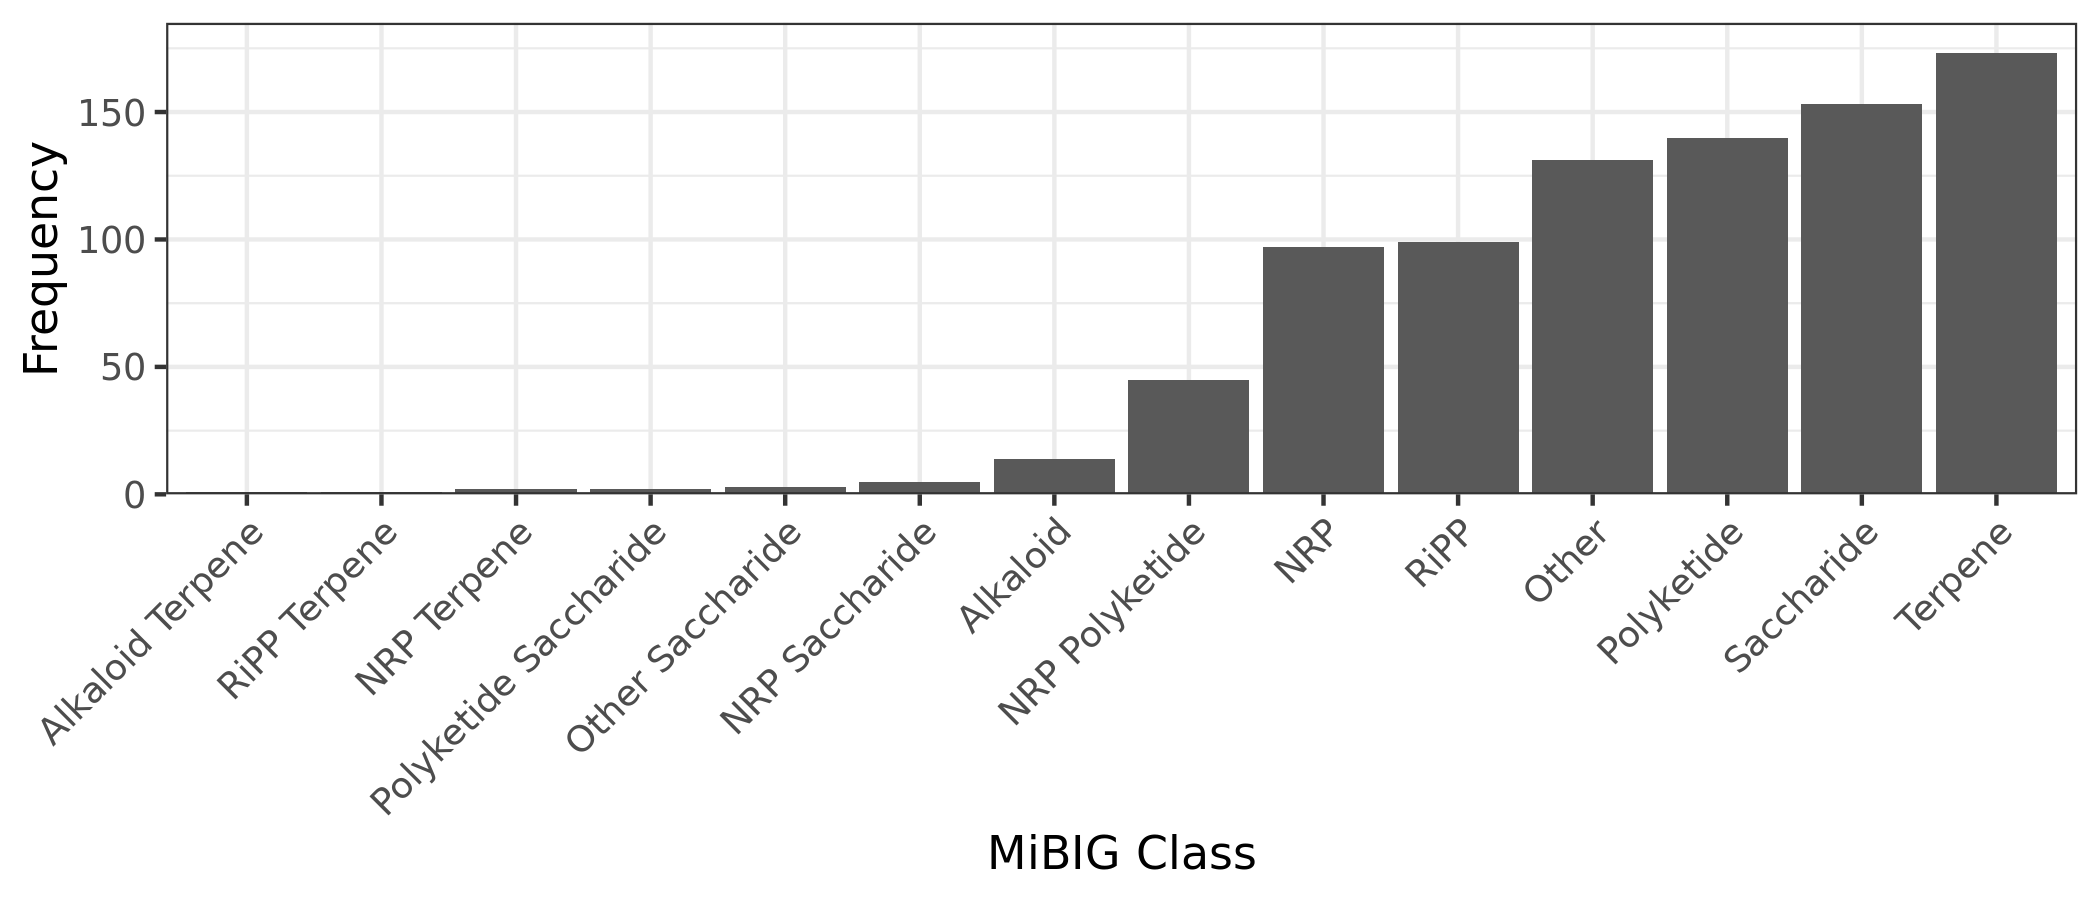

In [164]:
options(repr.plot.width = 7, repr.plot.height = 3, repr.plot.res = 300)

ggplot(subset_emerald, aes(reorder(mibig_class, desc(mibig_class), length)))+geom_histogram(stat = "count")+theme_bw()+scale_y_continuous(expand = c(0,0), limits = c(0, 185))+theme(axis.text.x = element_text(angle = 45, hjust = 1))+labs(x = "MiBIG Class", y = "Frequency")

In [32]:
subset_emerald_classes <- subset_emerald[, c("sample", "mibig_class")] %>% group_by(sample,mibig_class) %>%summarise(count=n())

`summarise()` has grouped output by 'sample'. You can override using the `.groups` argument.


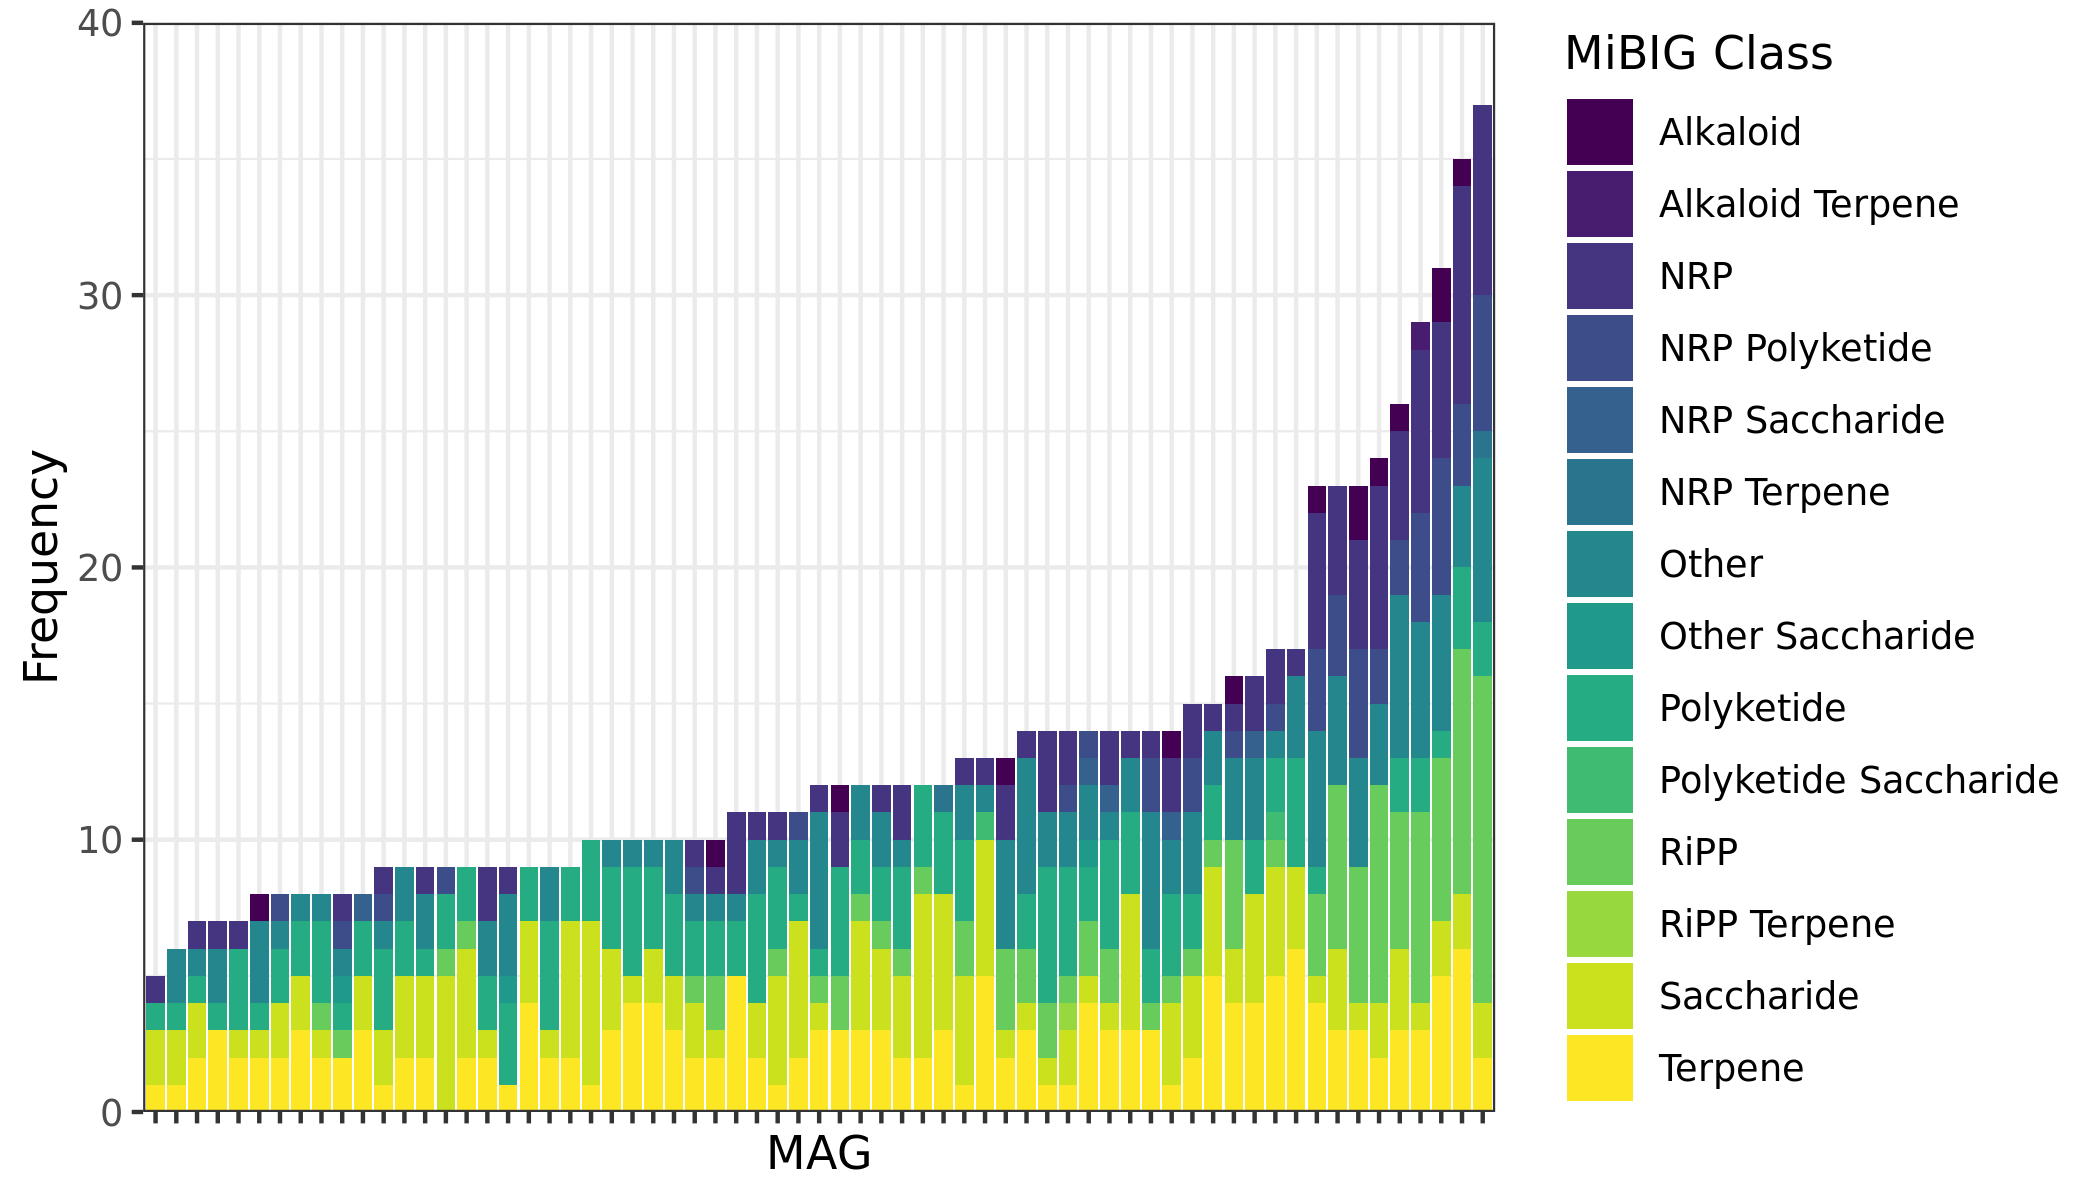

In [191]:
options(repr.plot.width = 7, repr.plot.height = 4, repr.plot.res = 300)

ggplot(subset_emerald_classes, aes(x = reorder(sample, count, sum), y = count, fill = mibig_class))+geom_bar(position="stack", stat="identity")+theme_bw()+scale_fill_viridis_d()+scale_y_continuous(limits = c(0, 40), expand = c(0,0))+theme(axis.text.x = element_blank())+labs(x = "MAG", y = "Frequency", fill = "MiBIG Class")

In [34]:
subset_emerald_total <- subset_emerald_classes[, c("sample", "count")] %>% group_by(sample) %>%summarise(count=sum(count))

In [58]:
unique(subset_emerald$mibig_class)
hybridclasses <- c("Polyketide Saccharide", "Other Saccharide", "NRP Polyketide", "NRP Terpene", "Alkaloid Terpene", "RiPP Terpene", "NRP Saccharide")
mainclasses <- c("Polyketide", "NRP", "RiPP", "Terpene", "Saccharide", "Alkaloid", "Other")
classlistnames <- c("Polyketide", "NRP", "RiPP", "Terpene", "Saccharide", "Alkaloid", "Other", "Hybrid")
subset_classlist <- vector("list", length(mainclasses))
for (i in 1:length(mainclasses)){
    subset_classlist[[i]] <- subset_emerald[subset_emerald$mibig_class == mainclasses[i],]
}

subset_classlist[[8]] <- subset_emerald[subset_emerald$mibig_class %in% hybridclasses,]

names(subset_classlist) <- classlistnames

[1] "Polyketide"            "Polyketide Saccharide" "NRP"                  
 [4] "RiPP"                  "Terpene"               "Saccharide"           
 [7] "Alkaloid"              "Other Saccharide"      "Other"                
[10] "NRP Polyketide"        "NRP Terpene"           "Alkaloid Terpene"     
[13] "RiPP Terpene"          "NRP Saccharide"

In [35]:
subset_emerald_matrix <- as.data.frame(subset_emerald[, c("sample", "nearest_mibig", "tax_classification", "mibig_class")] %>% group_by(sample, nearest_mibig, tax_classification) %>% summarise(count=n()) %>% spread(nearest_mibig, count, fill = 0))

`summarise()` has grouped output by 'sample', 'nearest_mibig'. You can override using the `.groups` argument.


In [165]:
heatmaps <- vector("list", length(subset_classlist))

for (i in 1:length(subset_classlist)){
    matrix <- as.data.frame(subset_classlist[[i]][,c("sample", "nearest_mibig", "tax_classification", "mibig_class")] %>% group_by(sample, nearest_mibig, tax_classification) %>% summarise(count=n()) %>% spread(nearest_mibig, count, fill = 0))    
    matrix$tax_classification <- paste0(substr(matrix$tax_classification,1,3),".")
    heatmaps[[i]] <- ComplexHeatmap::Heatmap(as.matrix(t(matrix[,-c(1,2)])), col = viridisLite::viridis(100), column_split = matrix$tax_classification)
    names(heatmaps) <- classlistnames
    heatmaps
    }

`summarise()` has grouped output by 'sample', 'nearest_mibig'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample', 'nearest_mibig'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample', 'nearest_mibig'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample', 'nearest_mibig'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample', 'nearest_mibig'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample', 'nearest_mibig'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample', 'nearest_mibig'. You can override using the `.groups` argument.
`summarise()` has grouped output by 'sample', 'nearest_mibig'. You can override using the `.groups` argument.


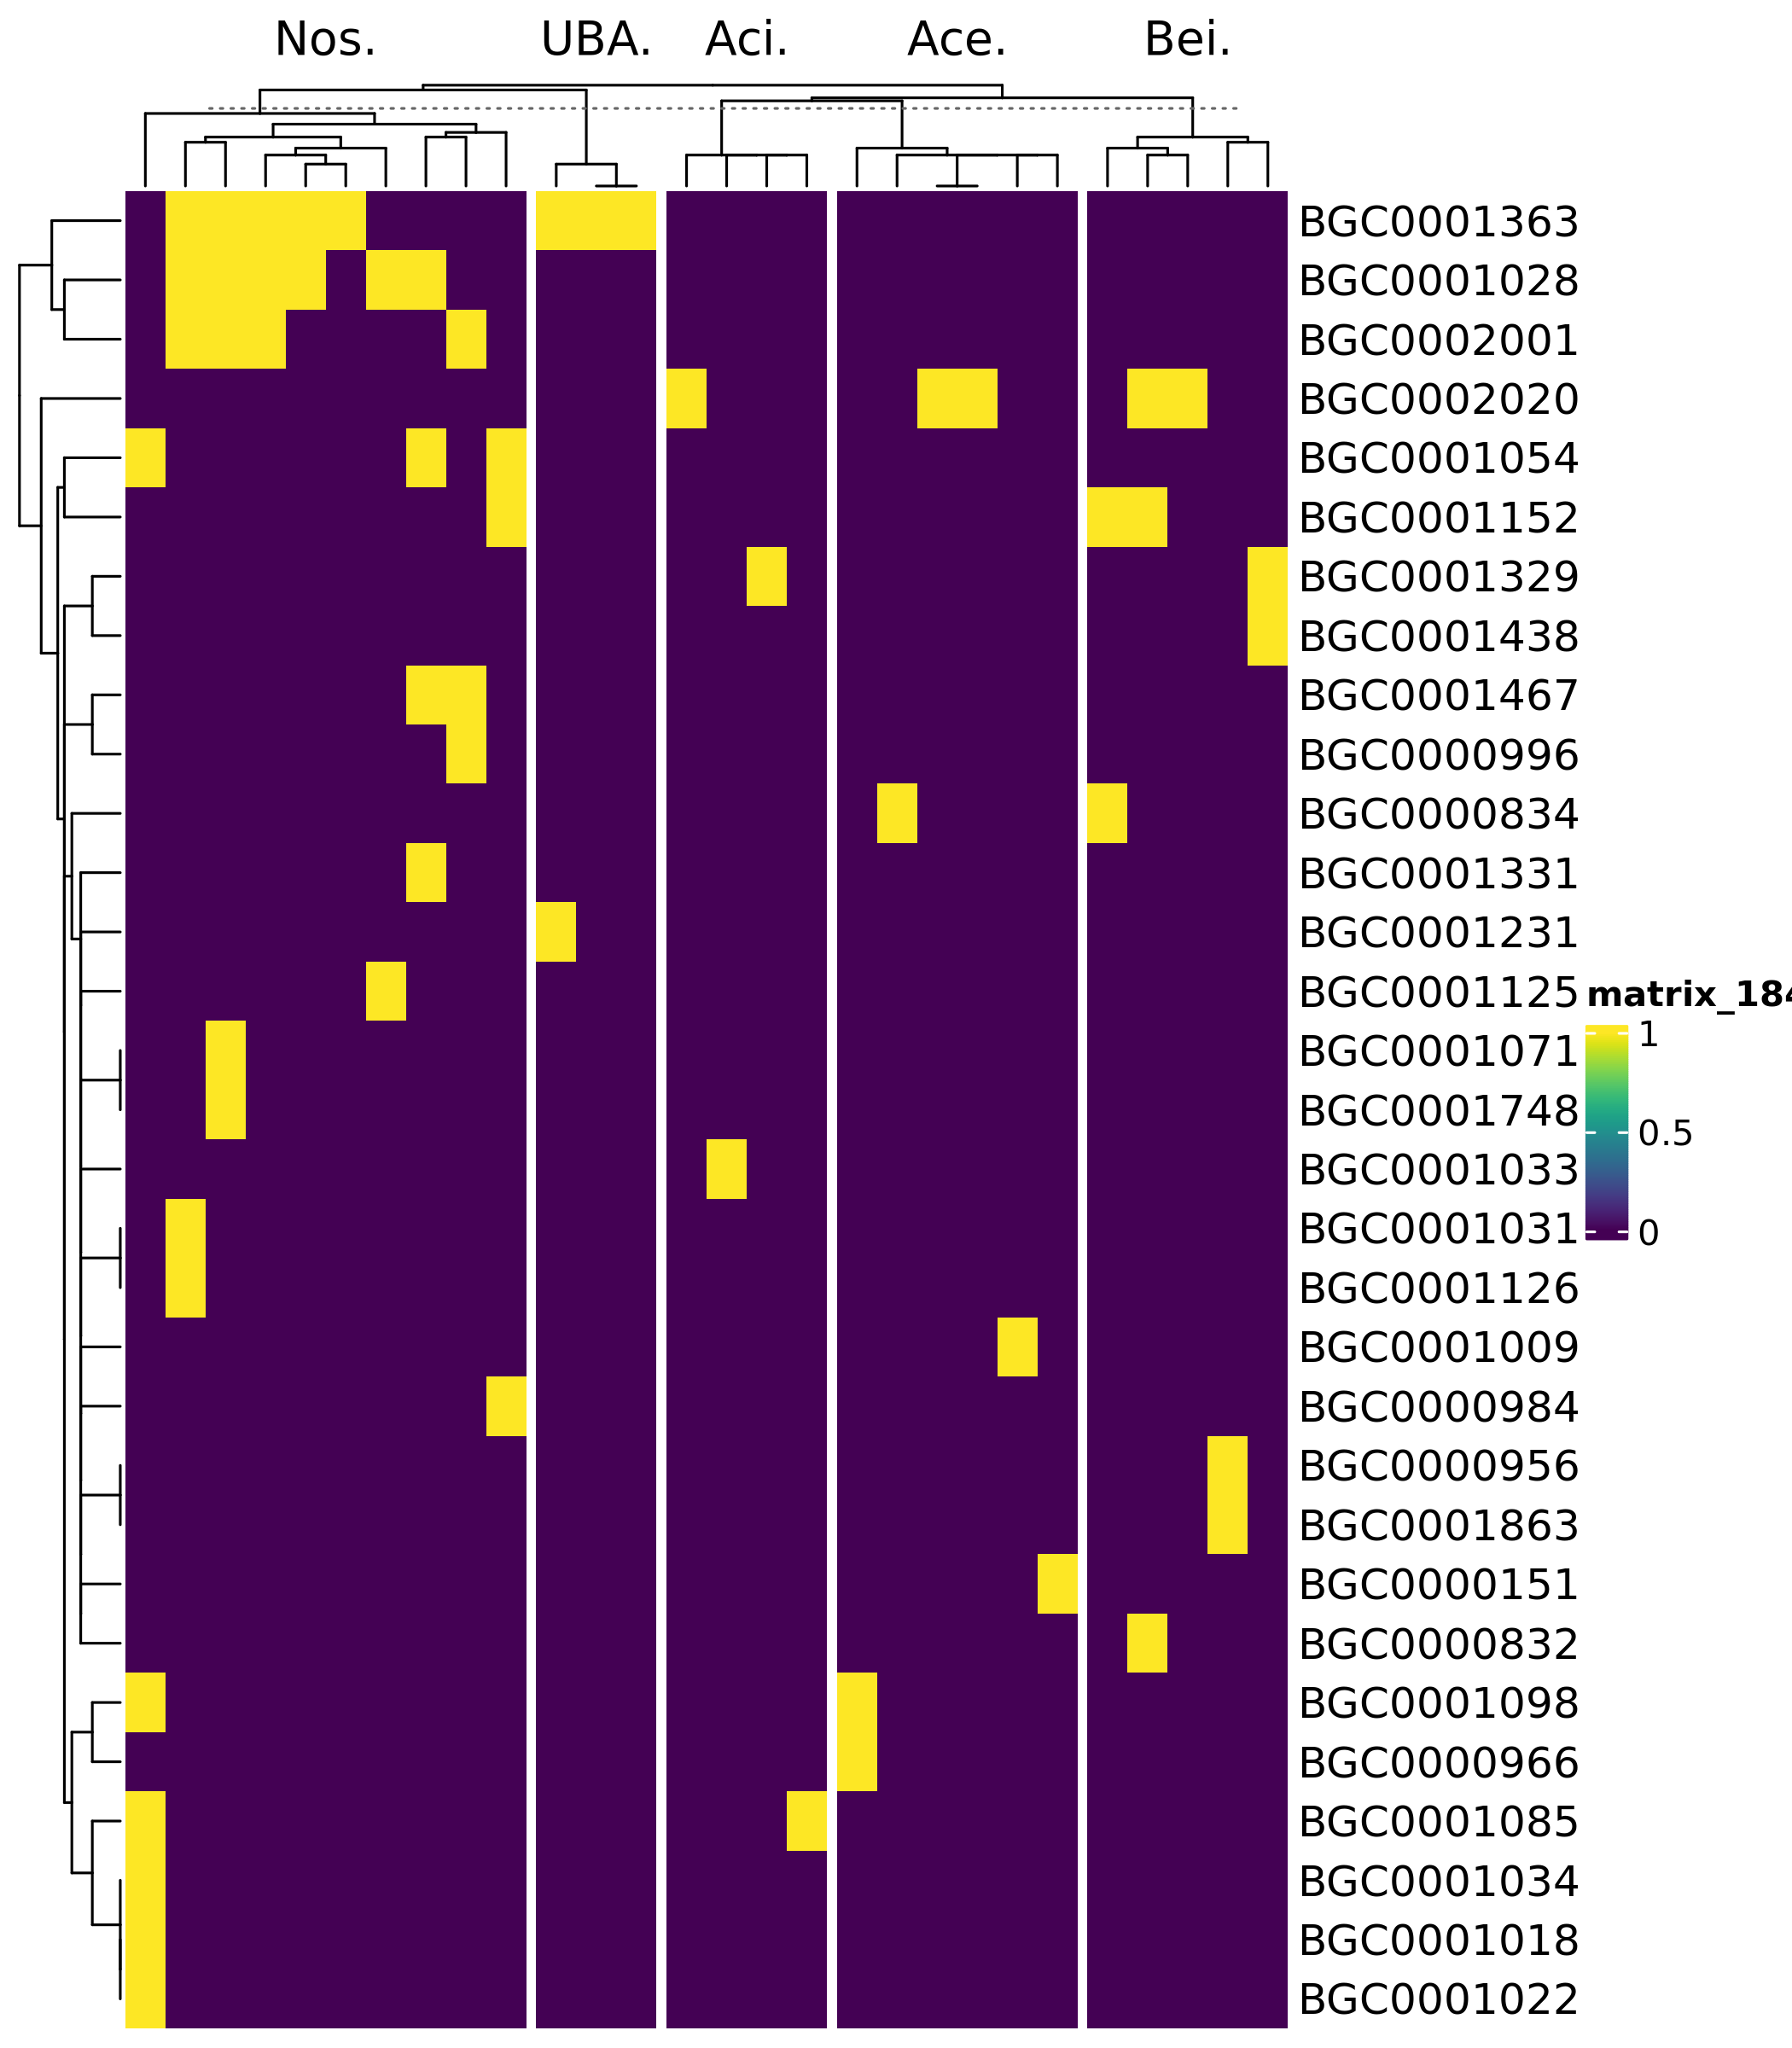

In [174]:
options(repr.plot.width = 7, repr.plot.height = 8, repr.plot.res = 300)


heatmaps[[8]]

In [164]:
subset_mibigclass <- as.data.frame(t(subset_emerald[,c("nearest_mibig", "mibig_class")]))

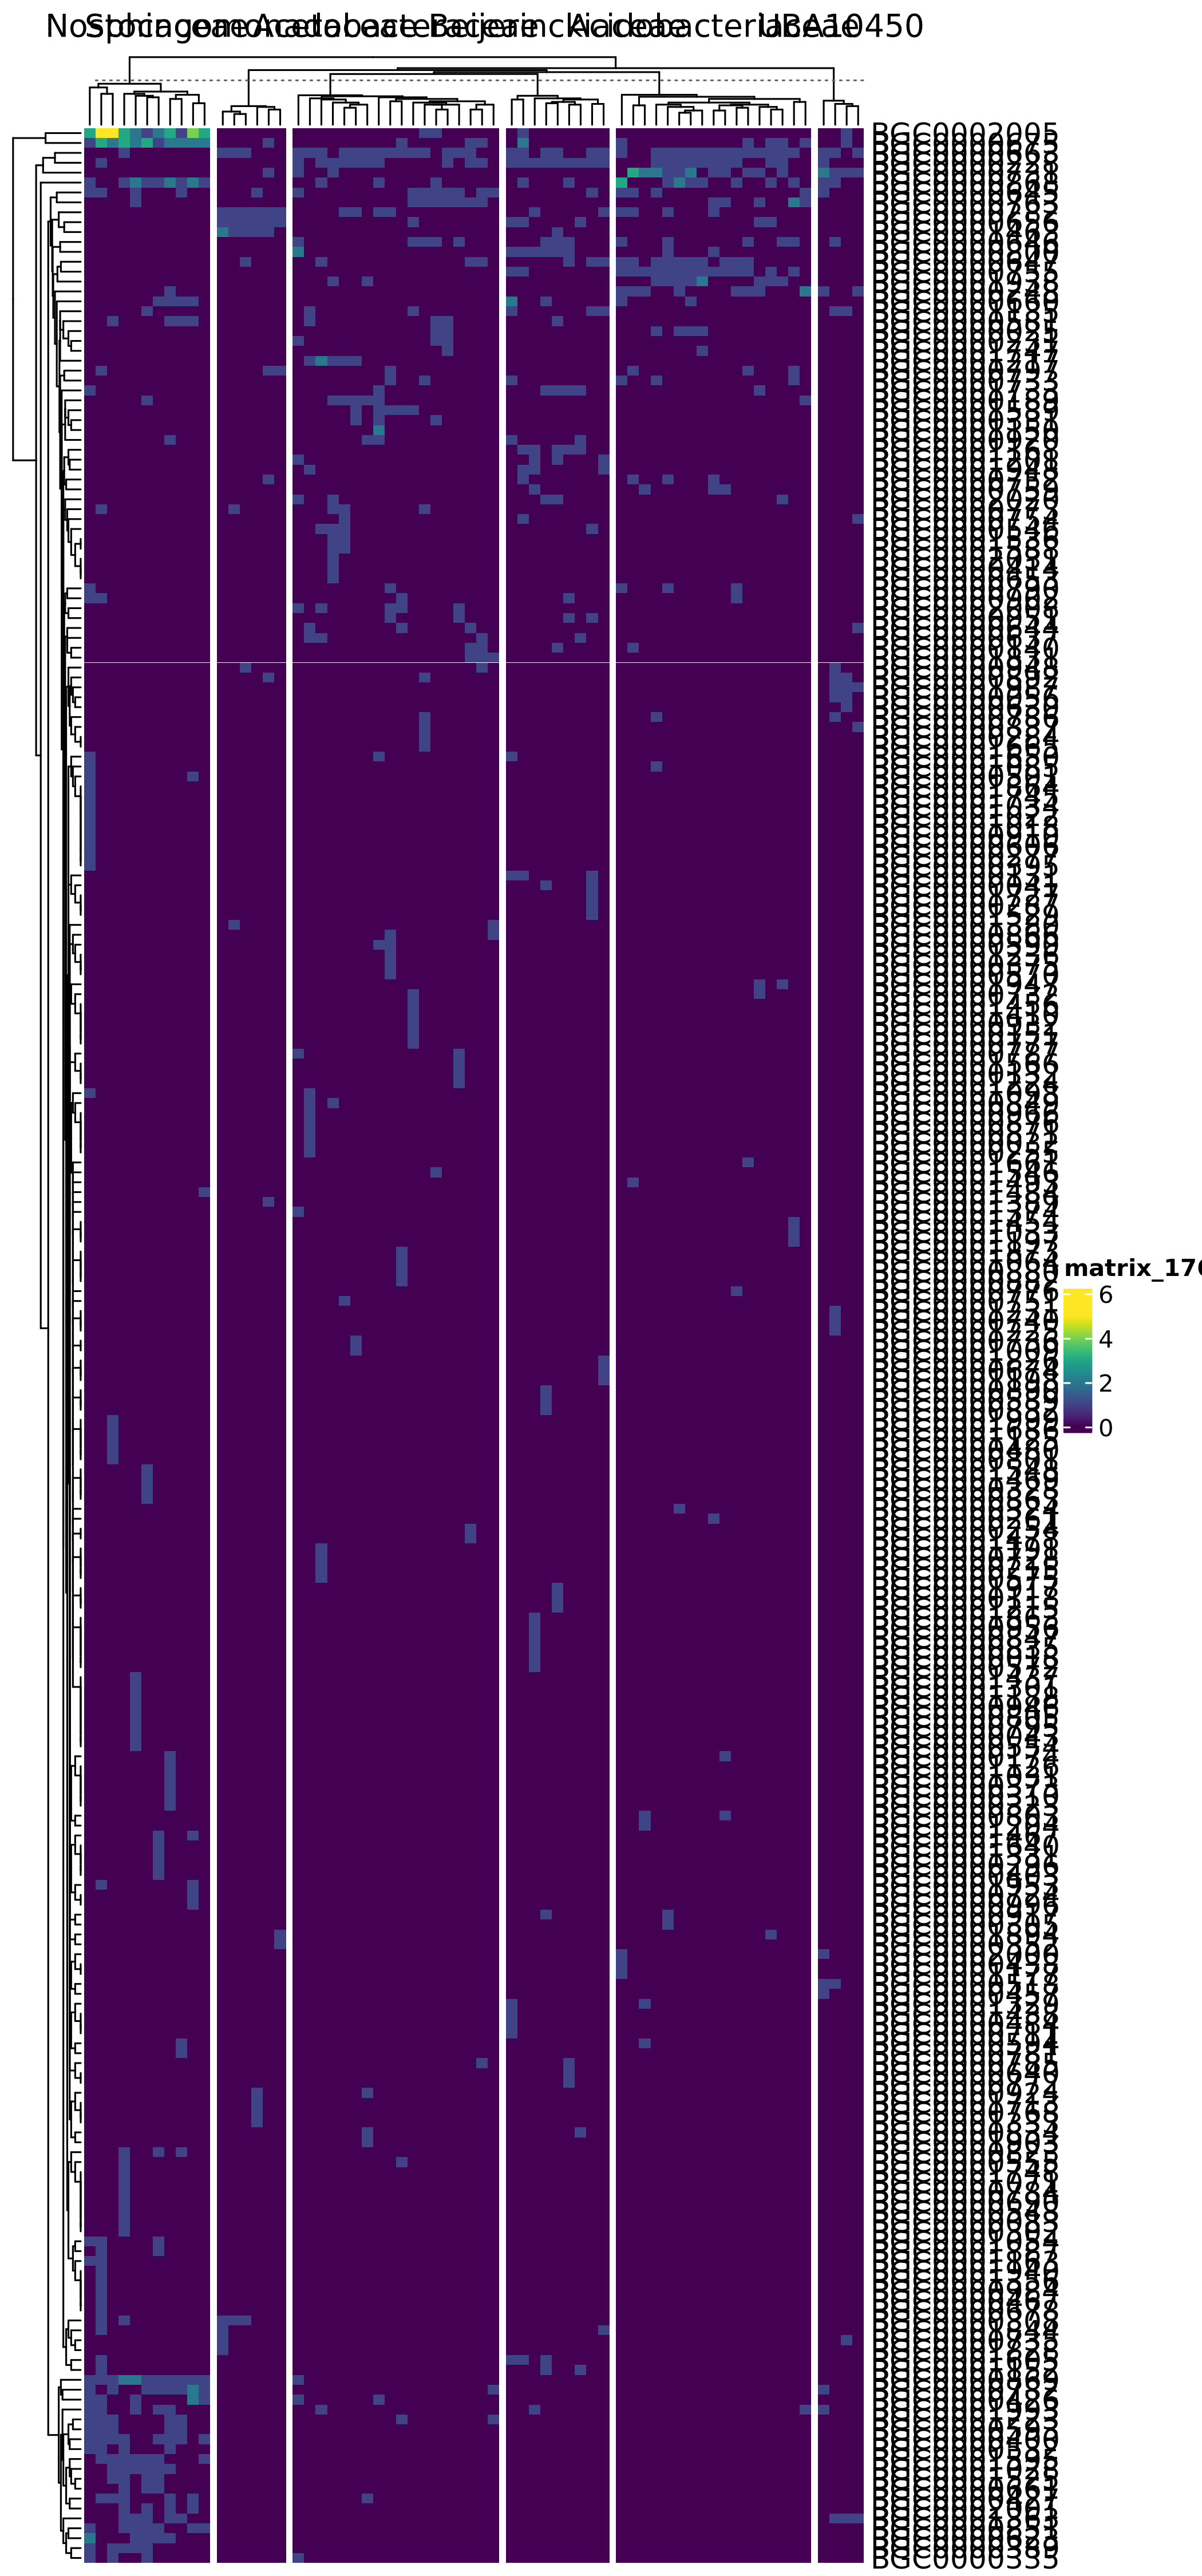

In [163]:
options(repr.plot.width = 7, repr.plot.height = 15, repr.plot.res = 300)

#col_fun <- circlize::colorRamp2(c(0, 7), c("white", "black"))
#col_fun(seq(-3, 3))
ComplexHeatmap::Heatmap(as.matrix(t(subset_emerald_matrix[,-c(1,2)])), col = viridisLite::viridis(100), column_split = subset_emerald_matrix$tax_classification, column_title = c("Nos.", "Sphing.", "Aceto.", "Burk.", "Acido.", "UBA"))

In [276]:
# Acetobacteraceae
subset_aceto <- subset_emerald[subset_emerald$tax_classification == "Acetobacteraceae",]
subset_aceto_classes <- subset_aceto[, c("sample", "mibig_class")] %>% group_by(sample,mibig_class) %>%summarise(count=n())

`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.


In [289]:
unique(subset_aceto$nearest_mibig)

[1] "BGC0002008" "BGC0000902" "BGC0000880" "BGC0001064" "BGC0000675"
  [6] "BGC0001589" "BGC0000644" "BGC0000882" "BGC0000663" "BGC0000555"
 [11] "BGC0001223" "BGC0001873" "BGC0000282" "BGC0001217" "BGC0000331"
 [16] "BGC0000736" "BGC0000228" "BGC0001009" "BGC0000189" "BGC0000575"
 [21] "BGC0001993" "BGC0000647" "BGC0000637" "BGC0000868" "BGC0000215"
 [26] "BGC0000546" "BGC0000728" "BGC0001191" "BGC0000426" "BGC0001733"
 [31] "BGC0000920" "BGC0001150" "BGC0001650" "BGC0000590" "BGC0000790"
 [36] "BGC0000733" "BGC0000570" "BGC0001236" "BGC0000375" "BGC0000866"
 [41] "BGC0000797" "BGC0000051" "BGC0000782" "BGC0001831" "BGC0001380"
 [46] "BGC0000645" "BGC0000254" "BGC0001478" "BGC0000140" "BGC0000763"
 [51] "BGC0000773" "BGC0000786" "BGC0002005" "BGC0000837" "BGC0001665"
 [56] "BGC0000646" "BGC0000284" "BGC0000892" "BGC0000231" "BGC0000581"
 [61] "BGC0000025" "BGC0001747" "BGC0000948" "BGC0000785" "BGC0000732"
 [66] "BGC0000151" "BGC0001135" "BGC0001456" "BGC0000656" "BGC0000932"
 [71] "BGC0001410" "BGC0000777" "BGC0000754" "BGC0000751" "BGC0001536"
 [76] "BGC0001588" "BGC0001224" "BGC0001566" "BGC0000787" "BGC0000132"
 [81] "BGC0000869" "BGC0002020" "BGC0000800" "BGC0001201" "BGC0000335"
 [86] "BGC0001374" "BGC0000731" "BGC0000924" "BGC0001938" "BGC0000834"
 [91] "BGC0001903" "BGC0000427" "BGC0000871" "BGC0001098" "BGC0000255"
 [96] "BGC0000966" "BGC0001948" "BGC0000032" "BGC0000849" "BGC0000876"
[101] "BGC0001546" "BGC0002031" "BGC0000414" "BGC0000653"

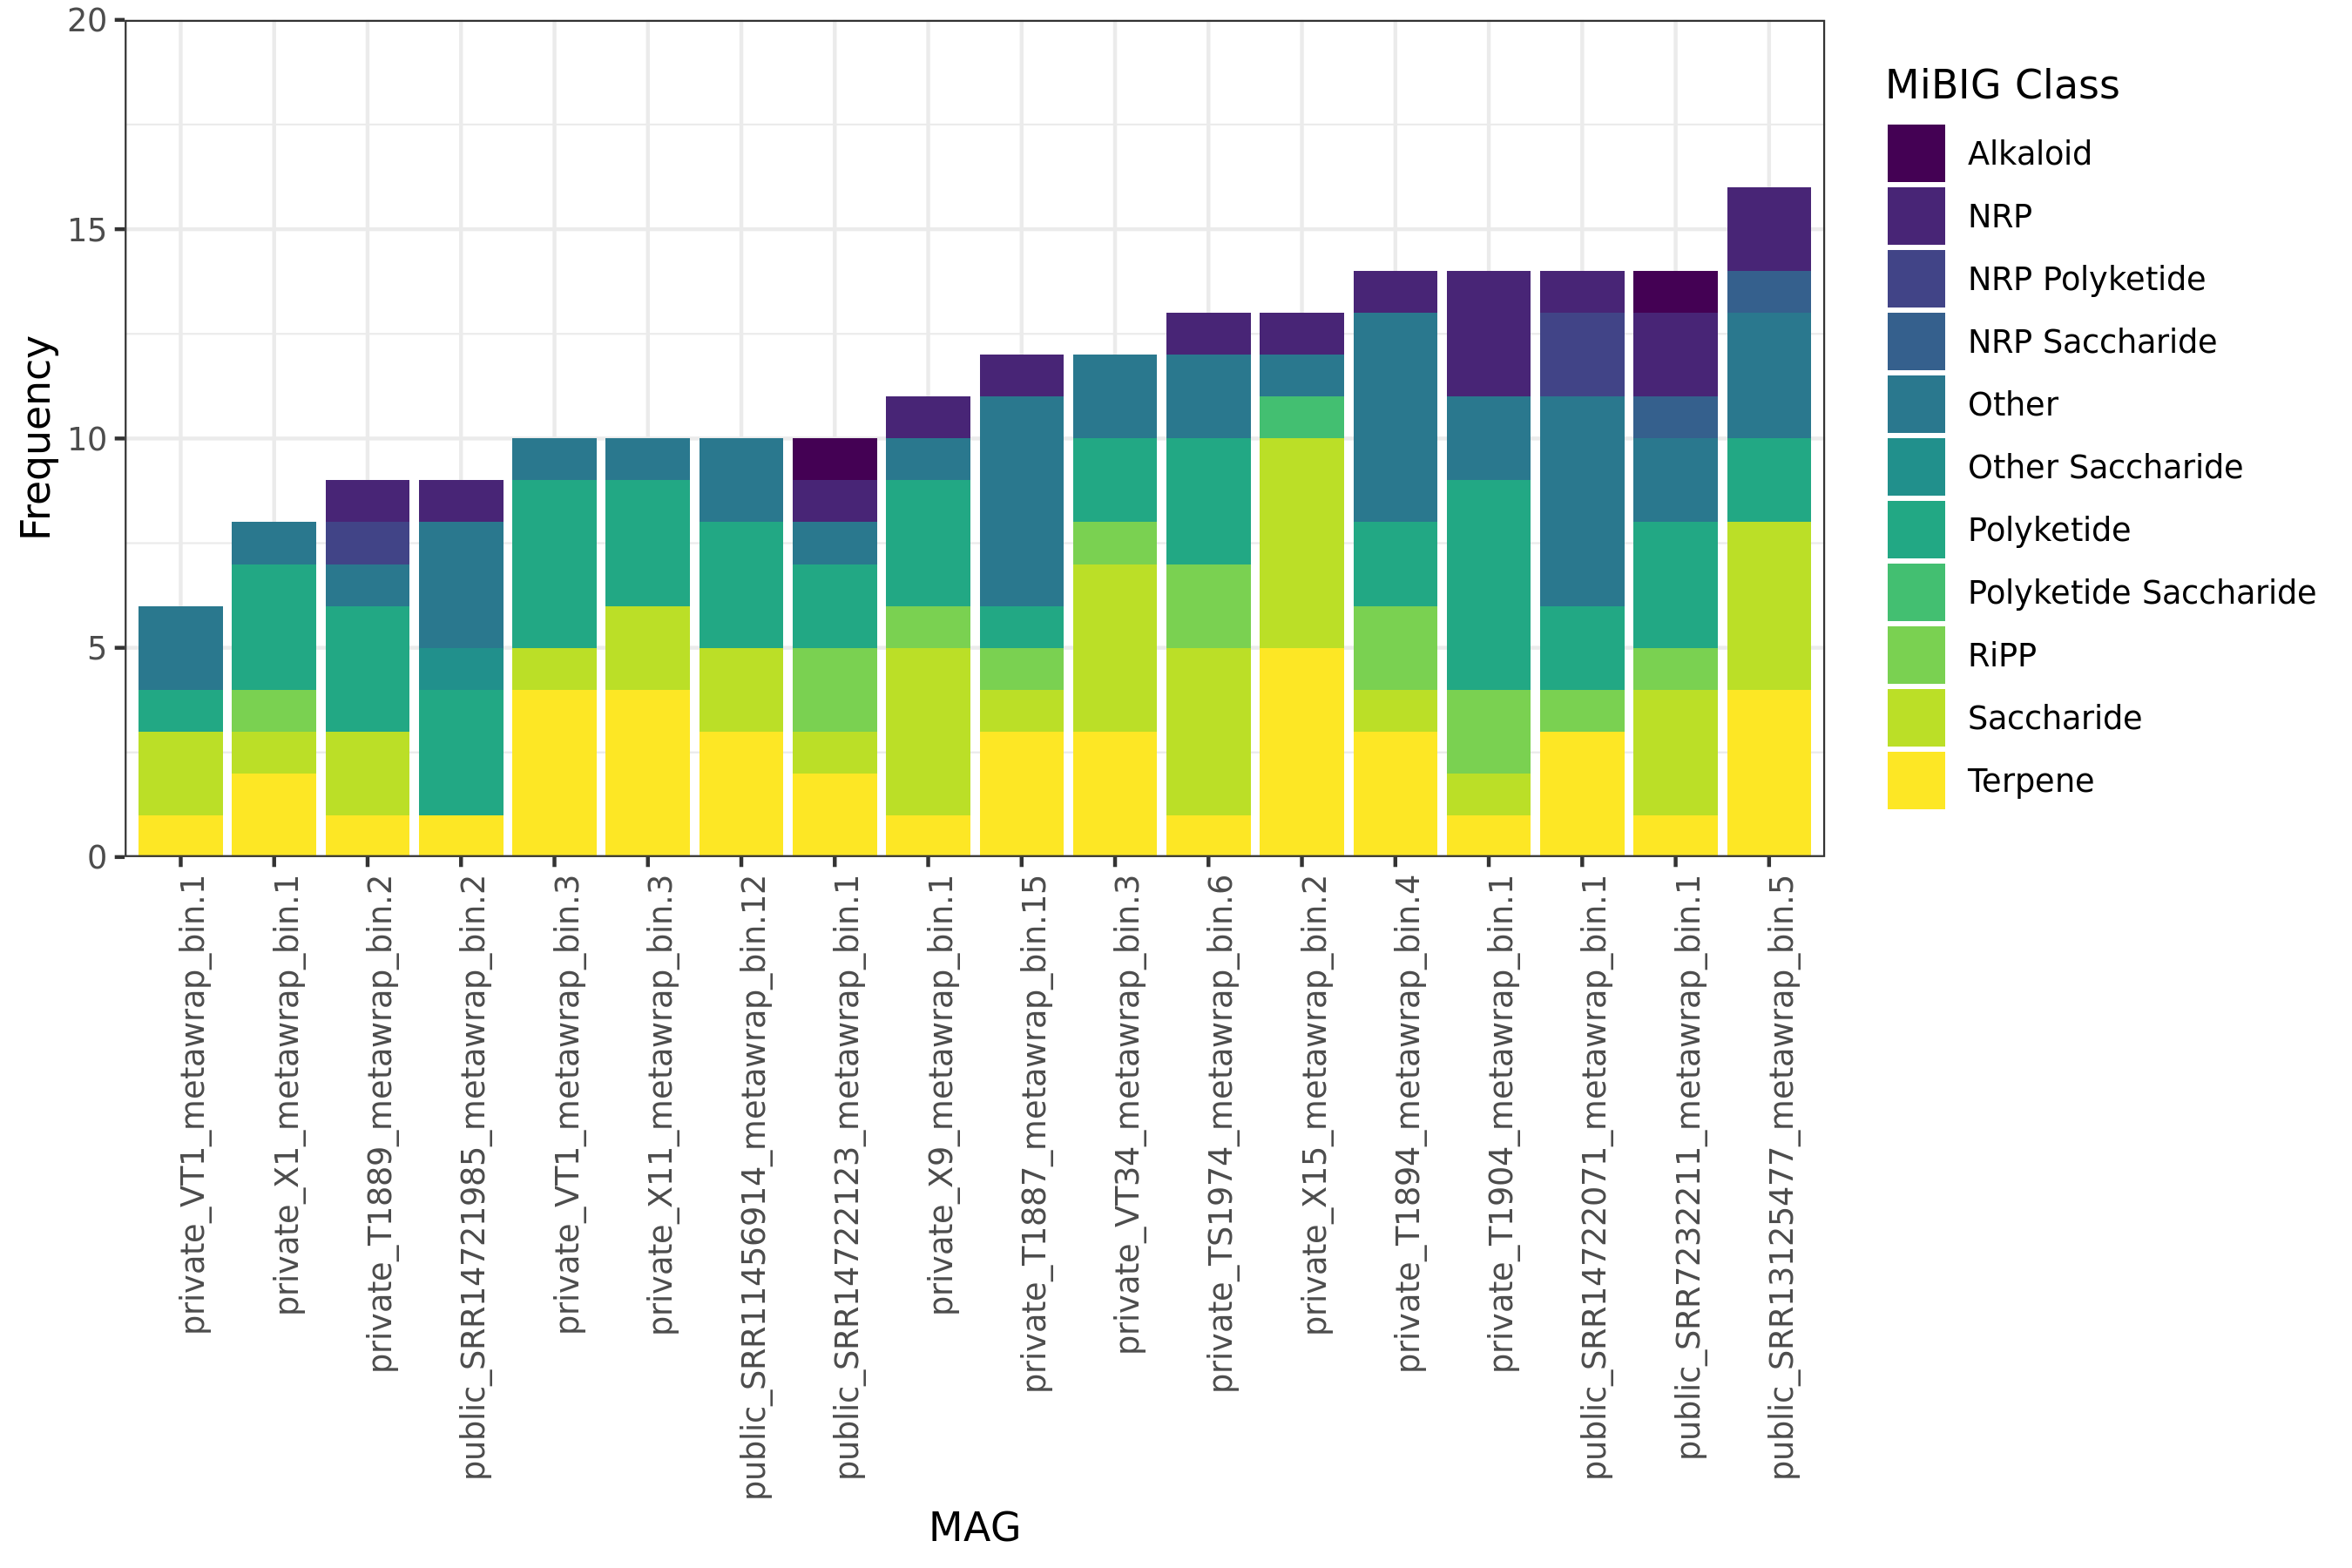

In [286]:
options(repr.plot.width = 9, repr.plot.height = 6, repr.plot.res = 300)

ggplot(subset_aceto_classes, aes(x = reorder(sample, count, sum), y = count, fill = mibig_class))+geom_bar(position="stack", stat="identity")+theme_bw()+scale_fill_viridis_d()+scale_y_continuous(limits = c(0, 20), expand = c(0,0))+labs(x = "MAG", y = "Frequency", fill = "MiBIG Class")+theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [290]:
# Beijerinckiaceae
subset_beij <- subset_emerald[subset_emerald$tax_classification == "Beijerinckiaceae",]
subset_beij_classes <- subset_beij[, c("sample", "mibig_class")] %>% group_by(sample,mibig_class) %>%summarise(count=n())

`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.


In [292]:
length(unique(subset_beij$nearest_mibig))

unique(subset_beij$nearest_mibig)

[1] 65

[1] "BGC0000663" "BGC0001135" "BGC0001826" "BGC0000647" "BGC0001198"
 [6] "BGC0001948" "BGC0000674" "BGC0001201" "BGC0000282" "BGC0001844"
[11] "BGC0000228" "BGC0000041" "BGC0000645" "BGC0001529" "BGC0000546"
[16] "BGC0000131" "BGC0000287" "BGC0000051" "BGC0001727" "BGC0001863"
[21] "BGC0001993" "BGC0000759" "BGC0000018" "BGC0000572" "BGC0001168"
[26] "BGC0000800" "BGC0000835" "BGC0000847" "BGC0000956" "BGC0000733"
[31] "BGC0000755" "BGC0000656" "BGC0001650" "BGC0000920" "BGC0001329"
[36] "BGC0000660" "BGC0001605" "BGC0000711" "BGC0000484" "BGC0001438"
[41] "BGC0000917" "BGC0001733" "BGC0002020" "BGC0000646" "BGC0000890"
[46] "BGC0000589" "BGC0000832" "BGC0001152" "BGC0000140" "BGC0001215"
[51] "BGC0001917" "BGC0000581" "BGC0000118" "BGC0001463" "BGC0000868"
[56] "BGC0000640" "BGC0000772" "BGC0000902" "BGC0000785" "BGC0000834"
[61] "BGC0000637" "BGC0000675" "BGC0002005" "BGC0000752" "BGC0000754"

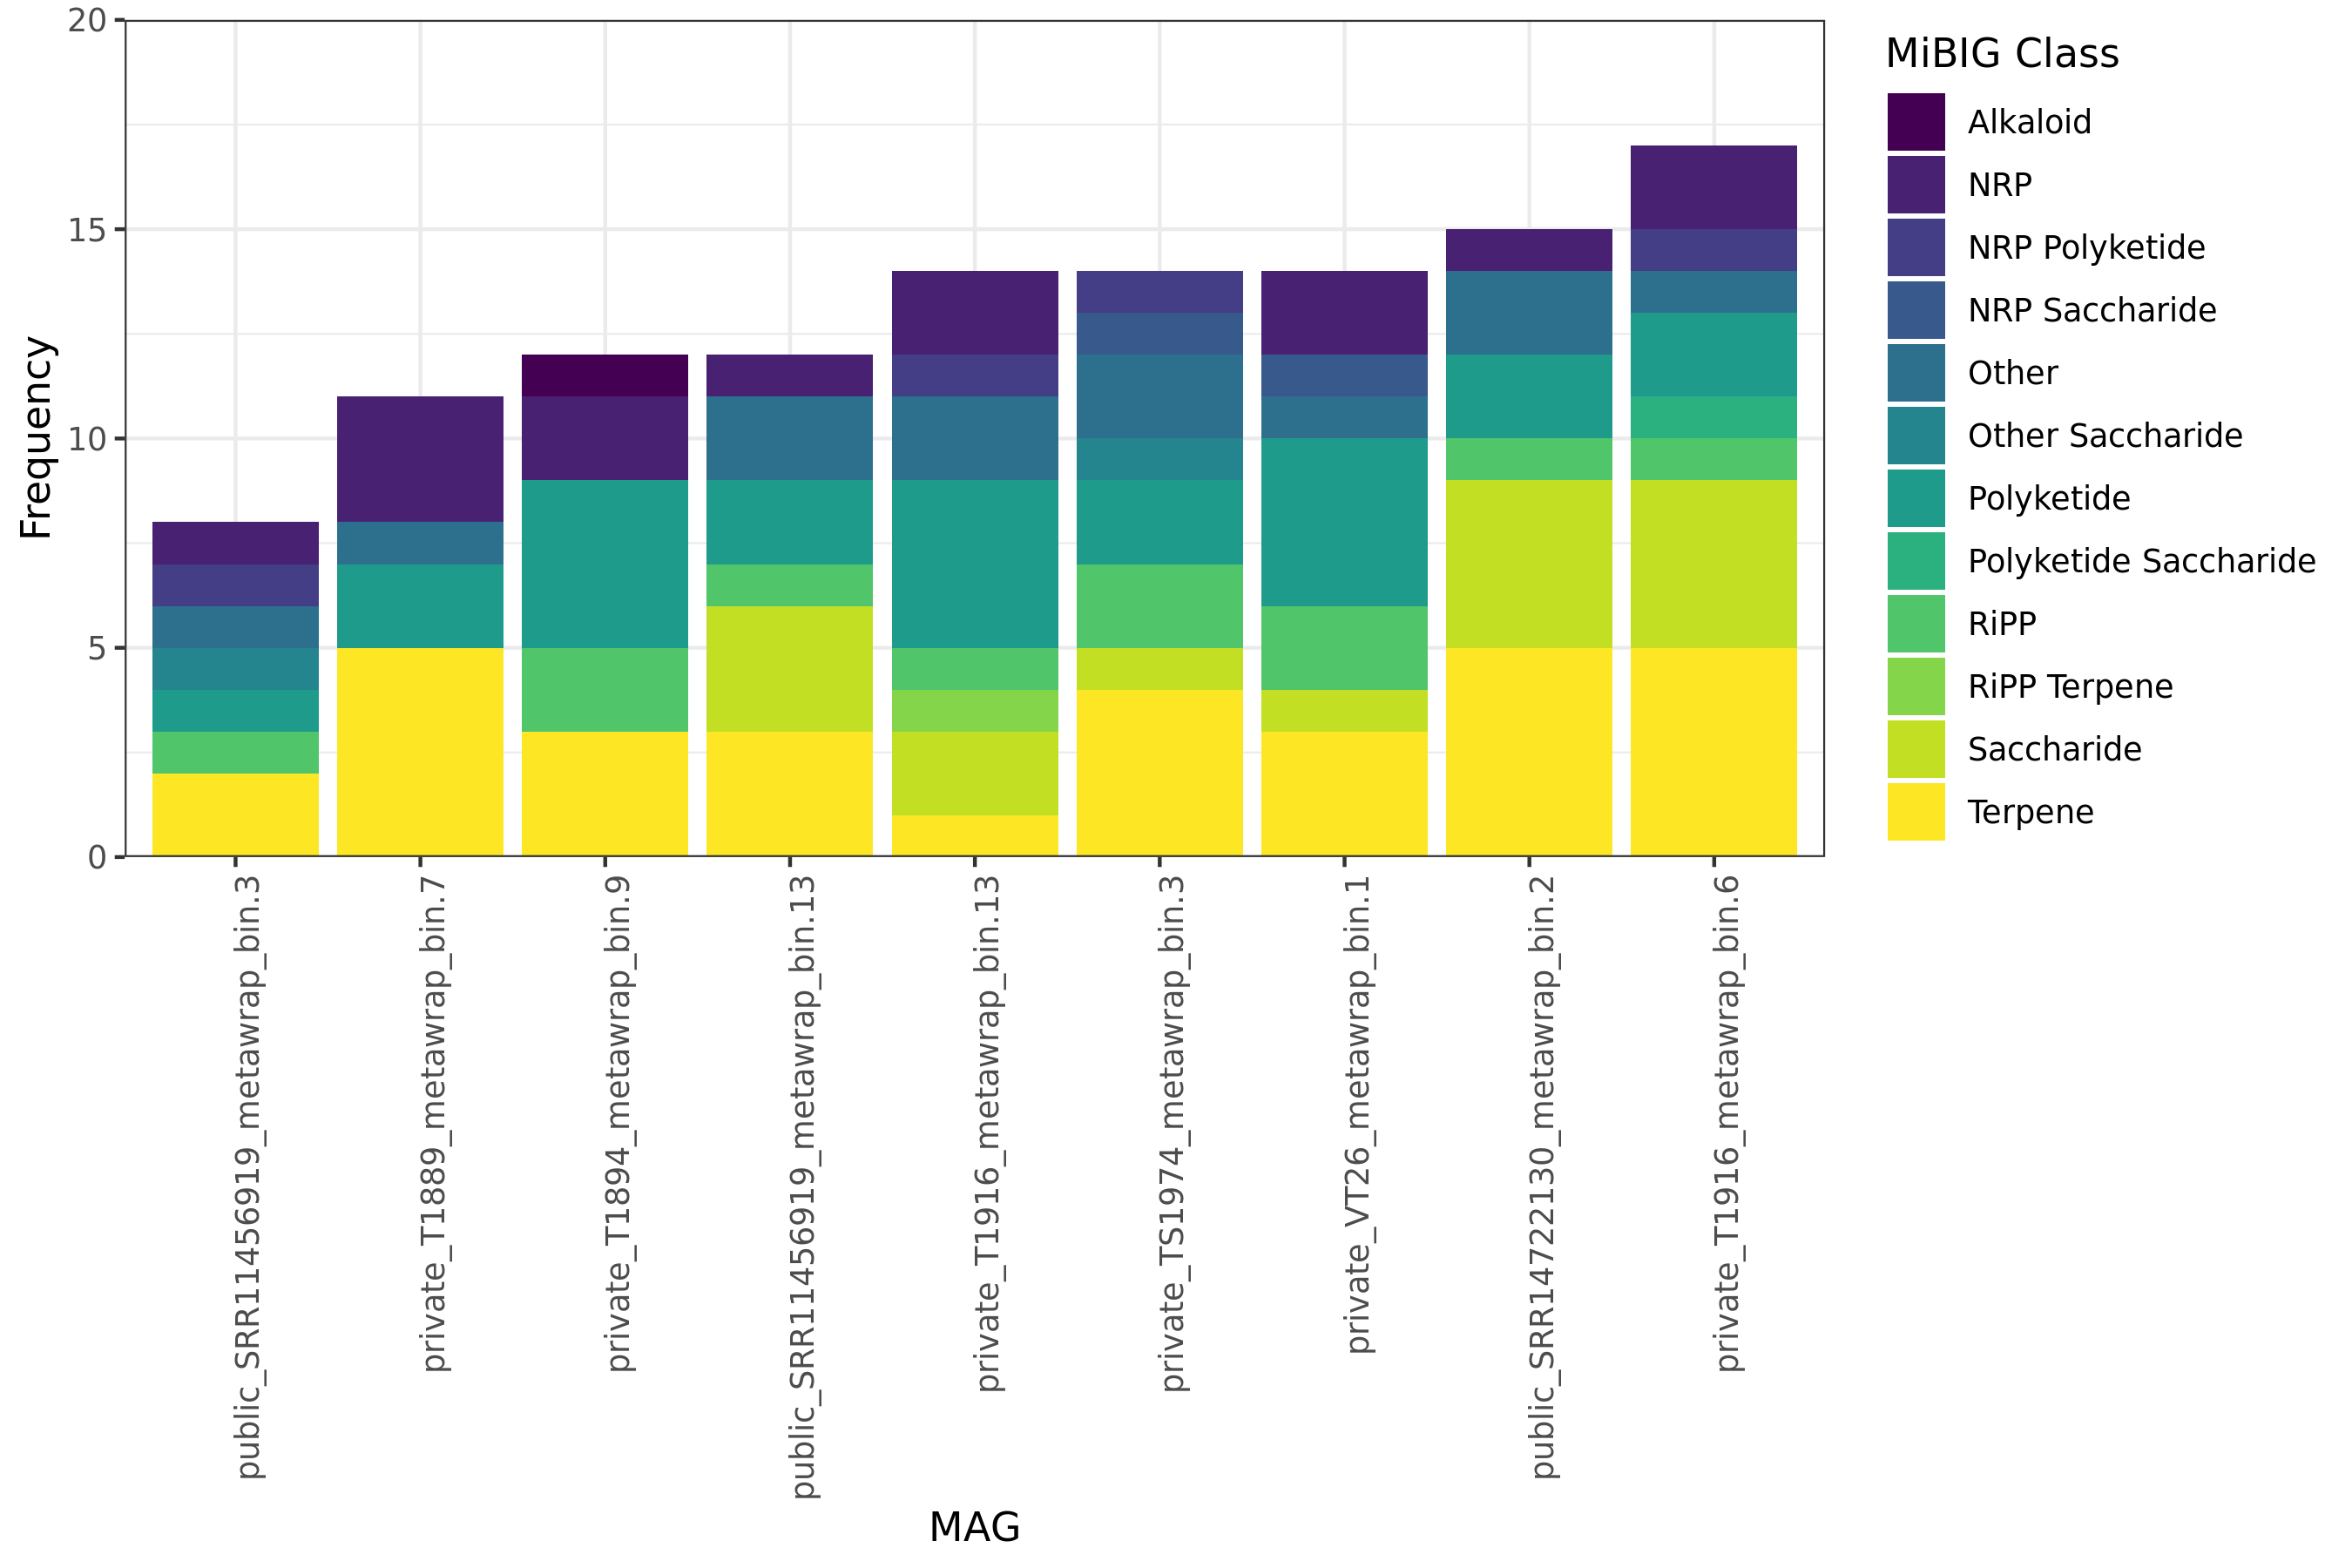

In [291]:
options(repr.plot.width = 9, repr.plot.height = 6, repr.plot.res = 300)

ggplot(subset_beij_classes, aes(x = reorder(sample, count, sum), y = count, fill = mibig_class))+geom_bar(position="stack", stat="identity")+theme_bw()+scale_fill_viridis_d()+scale_y_continuous(limits = c(0, 20), expand = c(0,0))+labs(x = "MAG", y = "Frequency", fill = "MiBIG Class")+theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [293]:
# Sphingomonadaceae
subset_sphing <- subset_emerald[subset_emerald$tax_classification == "Sphingomonadaceae",]
subset_sphing_classes <- subset_sphing[, c("sample", "mibig_class")] %>% group_by(sample,mibig_class) %>%summarise(count=n())

`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.


In [306]:
length(unique(subset_sphing$nearest_mibig))

unique(subset_sphing$nearest_mibig)

[1] 25

[1] "BGC0000645" "BGC0000768" "BGC0001463" "BGC0000282" "BGC0000924"
 [6] "BGC0001333" "BGC0001713" "BGC0000656" "BGC0000731" "BGC0000752"
[11] "BGC0000797" "BGC0000892" "BGC0000675" "BGC0001389" "BGC0000308"
[16] "BGC0000735" "BGC0001828" "BGC0001844" "BGC0000663" "BGC0001380"
[21] "BGC0000773" "BGC0000352" "BGC0001894" "BGC0000948" "BGC0000647"

In [307]:
unique(subset_emerald$tax_classification)

[1] "Acetobacteraceae"  "Sphingomonadaceae" "Acidobacteriaceae"
[4] "Beijerinckiaceae"  "UBA10450"          "Nostocaceae"

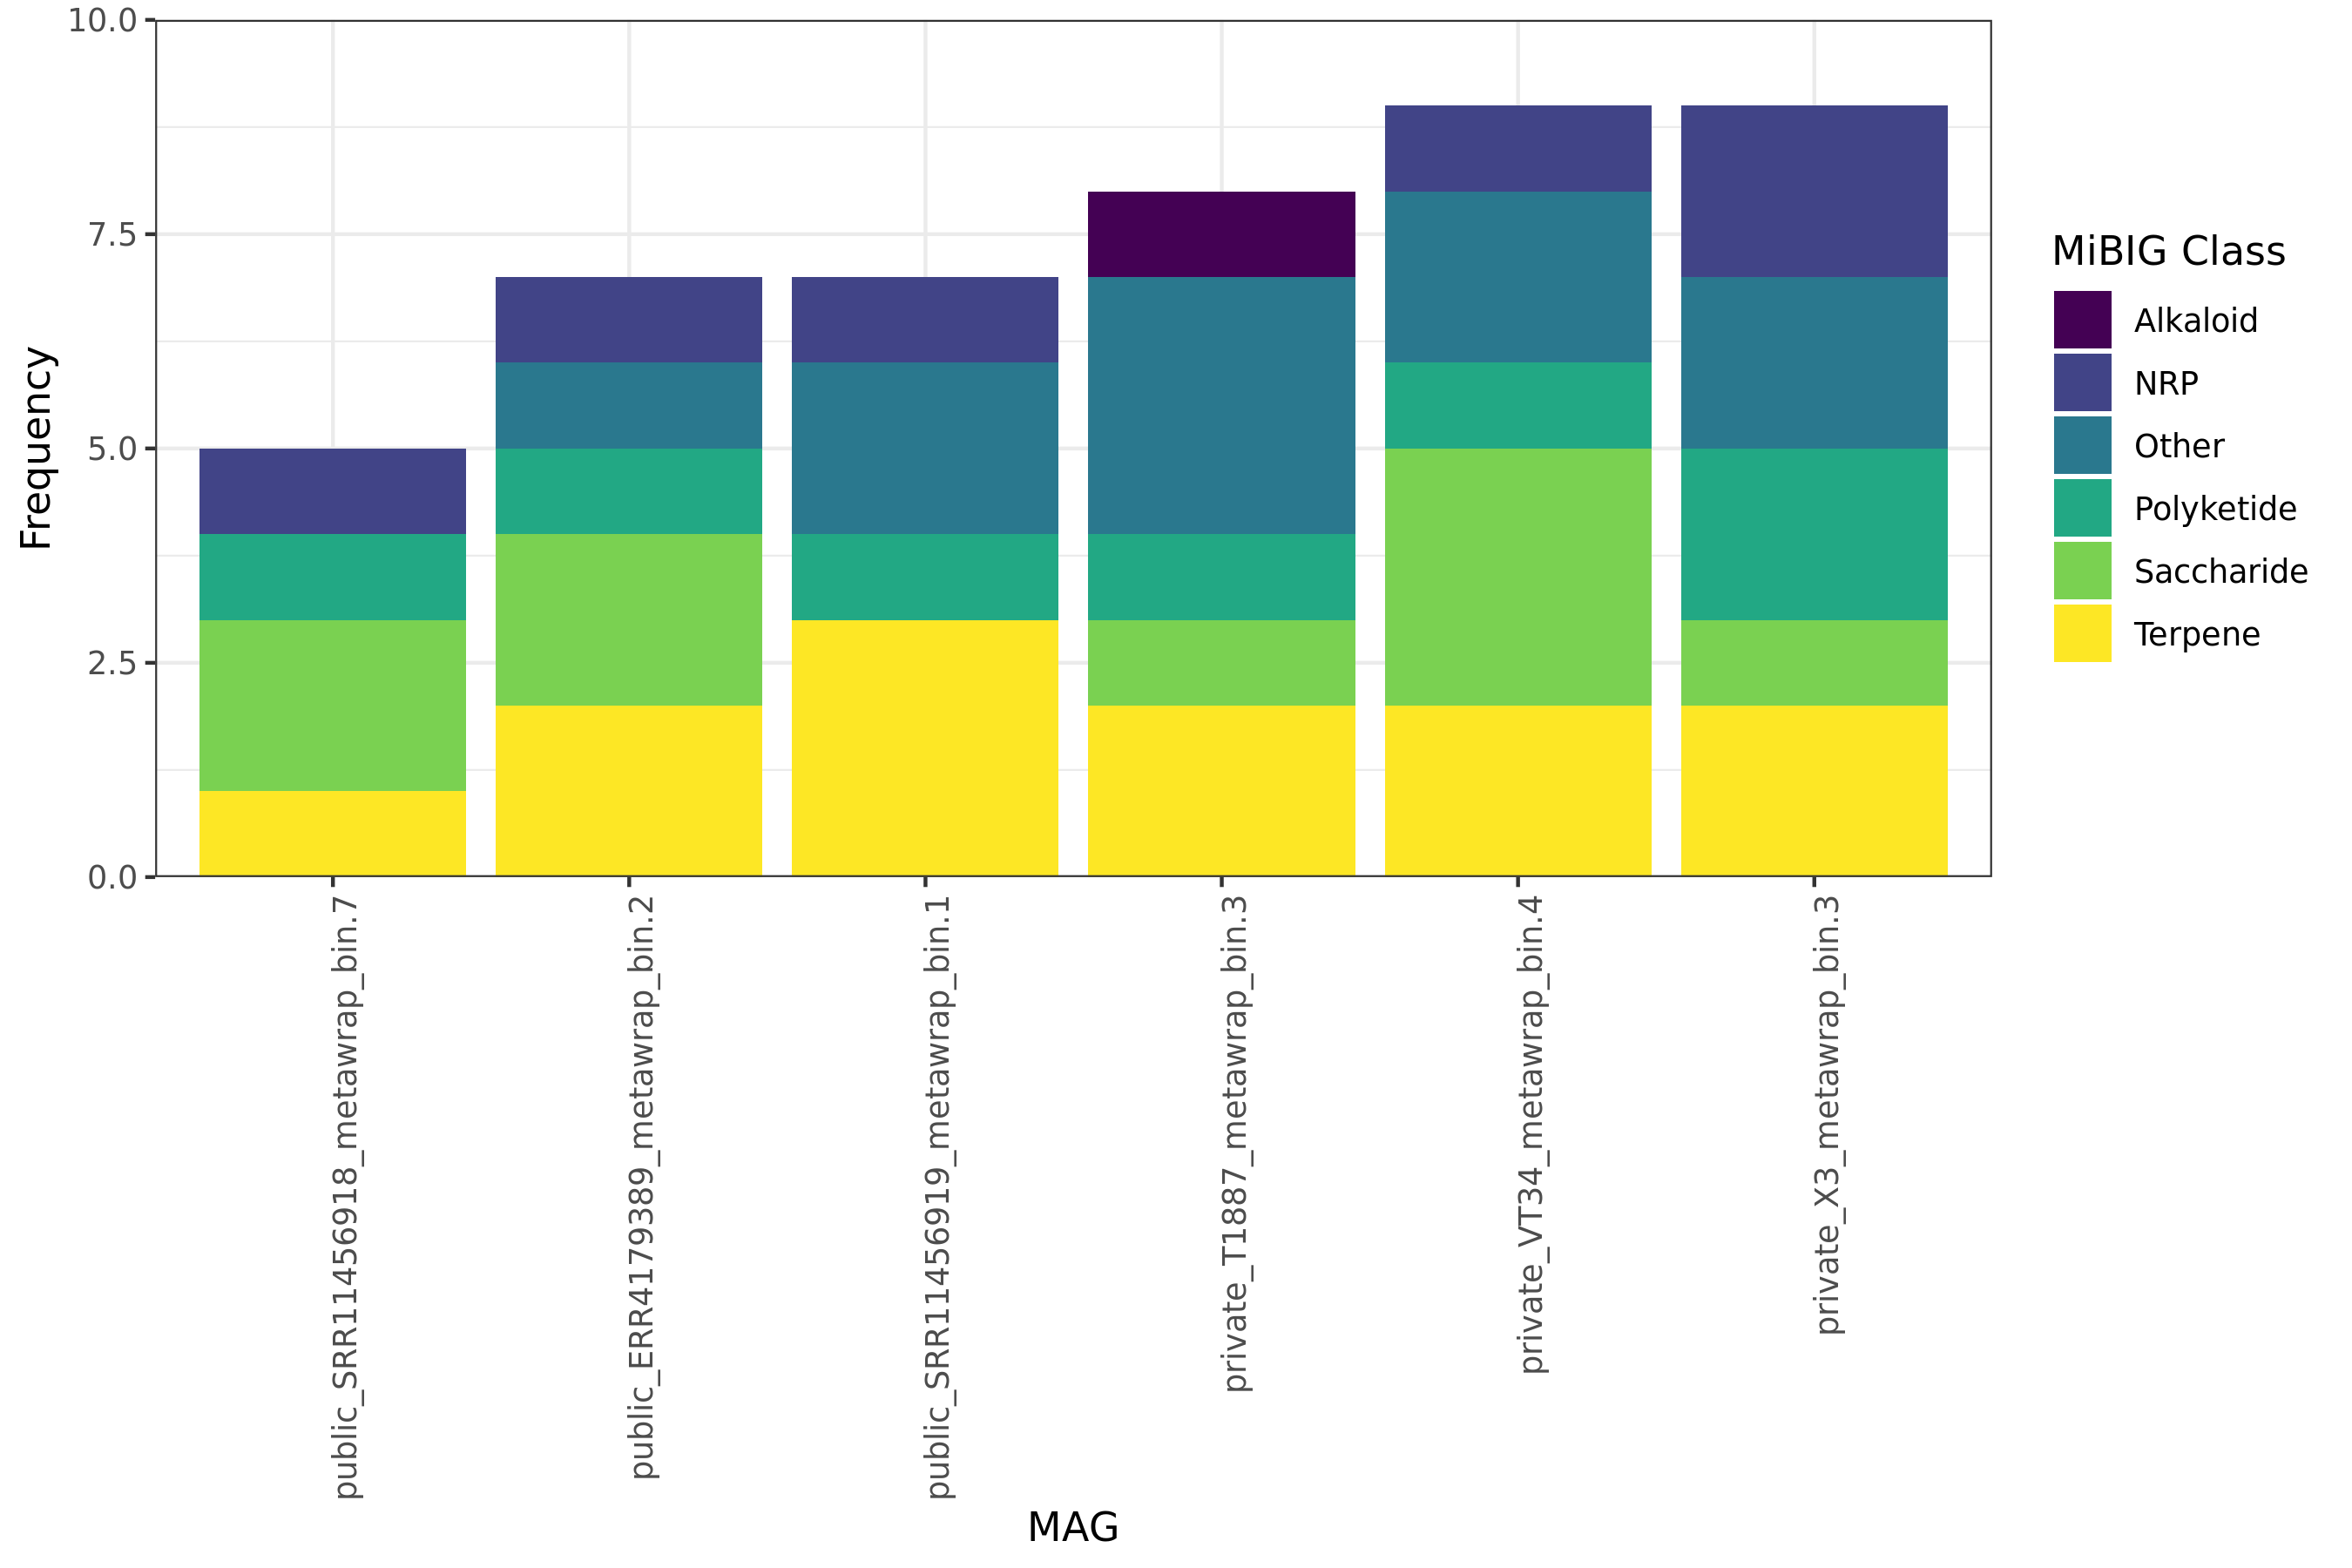

In [295]:
options(repr.plot.width = 9, repr.plot.height = 6, repr.plot.res = 300)

ggplot(subset_sphing_classes, aes(x = reorder(sample, count, sum), y = count, fill = mibig_class))+geom_bar(position="stack", stat="identity")+theme_bw()+scale_fill_viridis_d()+scale_y_continuous(limits = c(0, 10), expand = c(0,0))+labs(x = "MAG", y = "Frequency", fill = "MiBIG Class")+theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [299]:
# Acidobacteriaceae
subset_acido <- subset_emerald[subset_emerald$tax_classification == "Acidobacteriaceae",]
subset_acido_classes <- subset_acido[, c("sample", "mibig_class")] %>% group_by(sample,mibig_class) %>%summarise(count=n())

`summarise()` has grouped output by 'sample'. You can override using the
`.groups` argument.


In [ ]:
length(unique(subset_acido$nearest_mibig))

unique(subset_acido$nearest_mibig)

unique(subset_emerald$tax_classification)

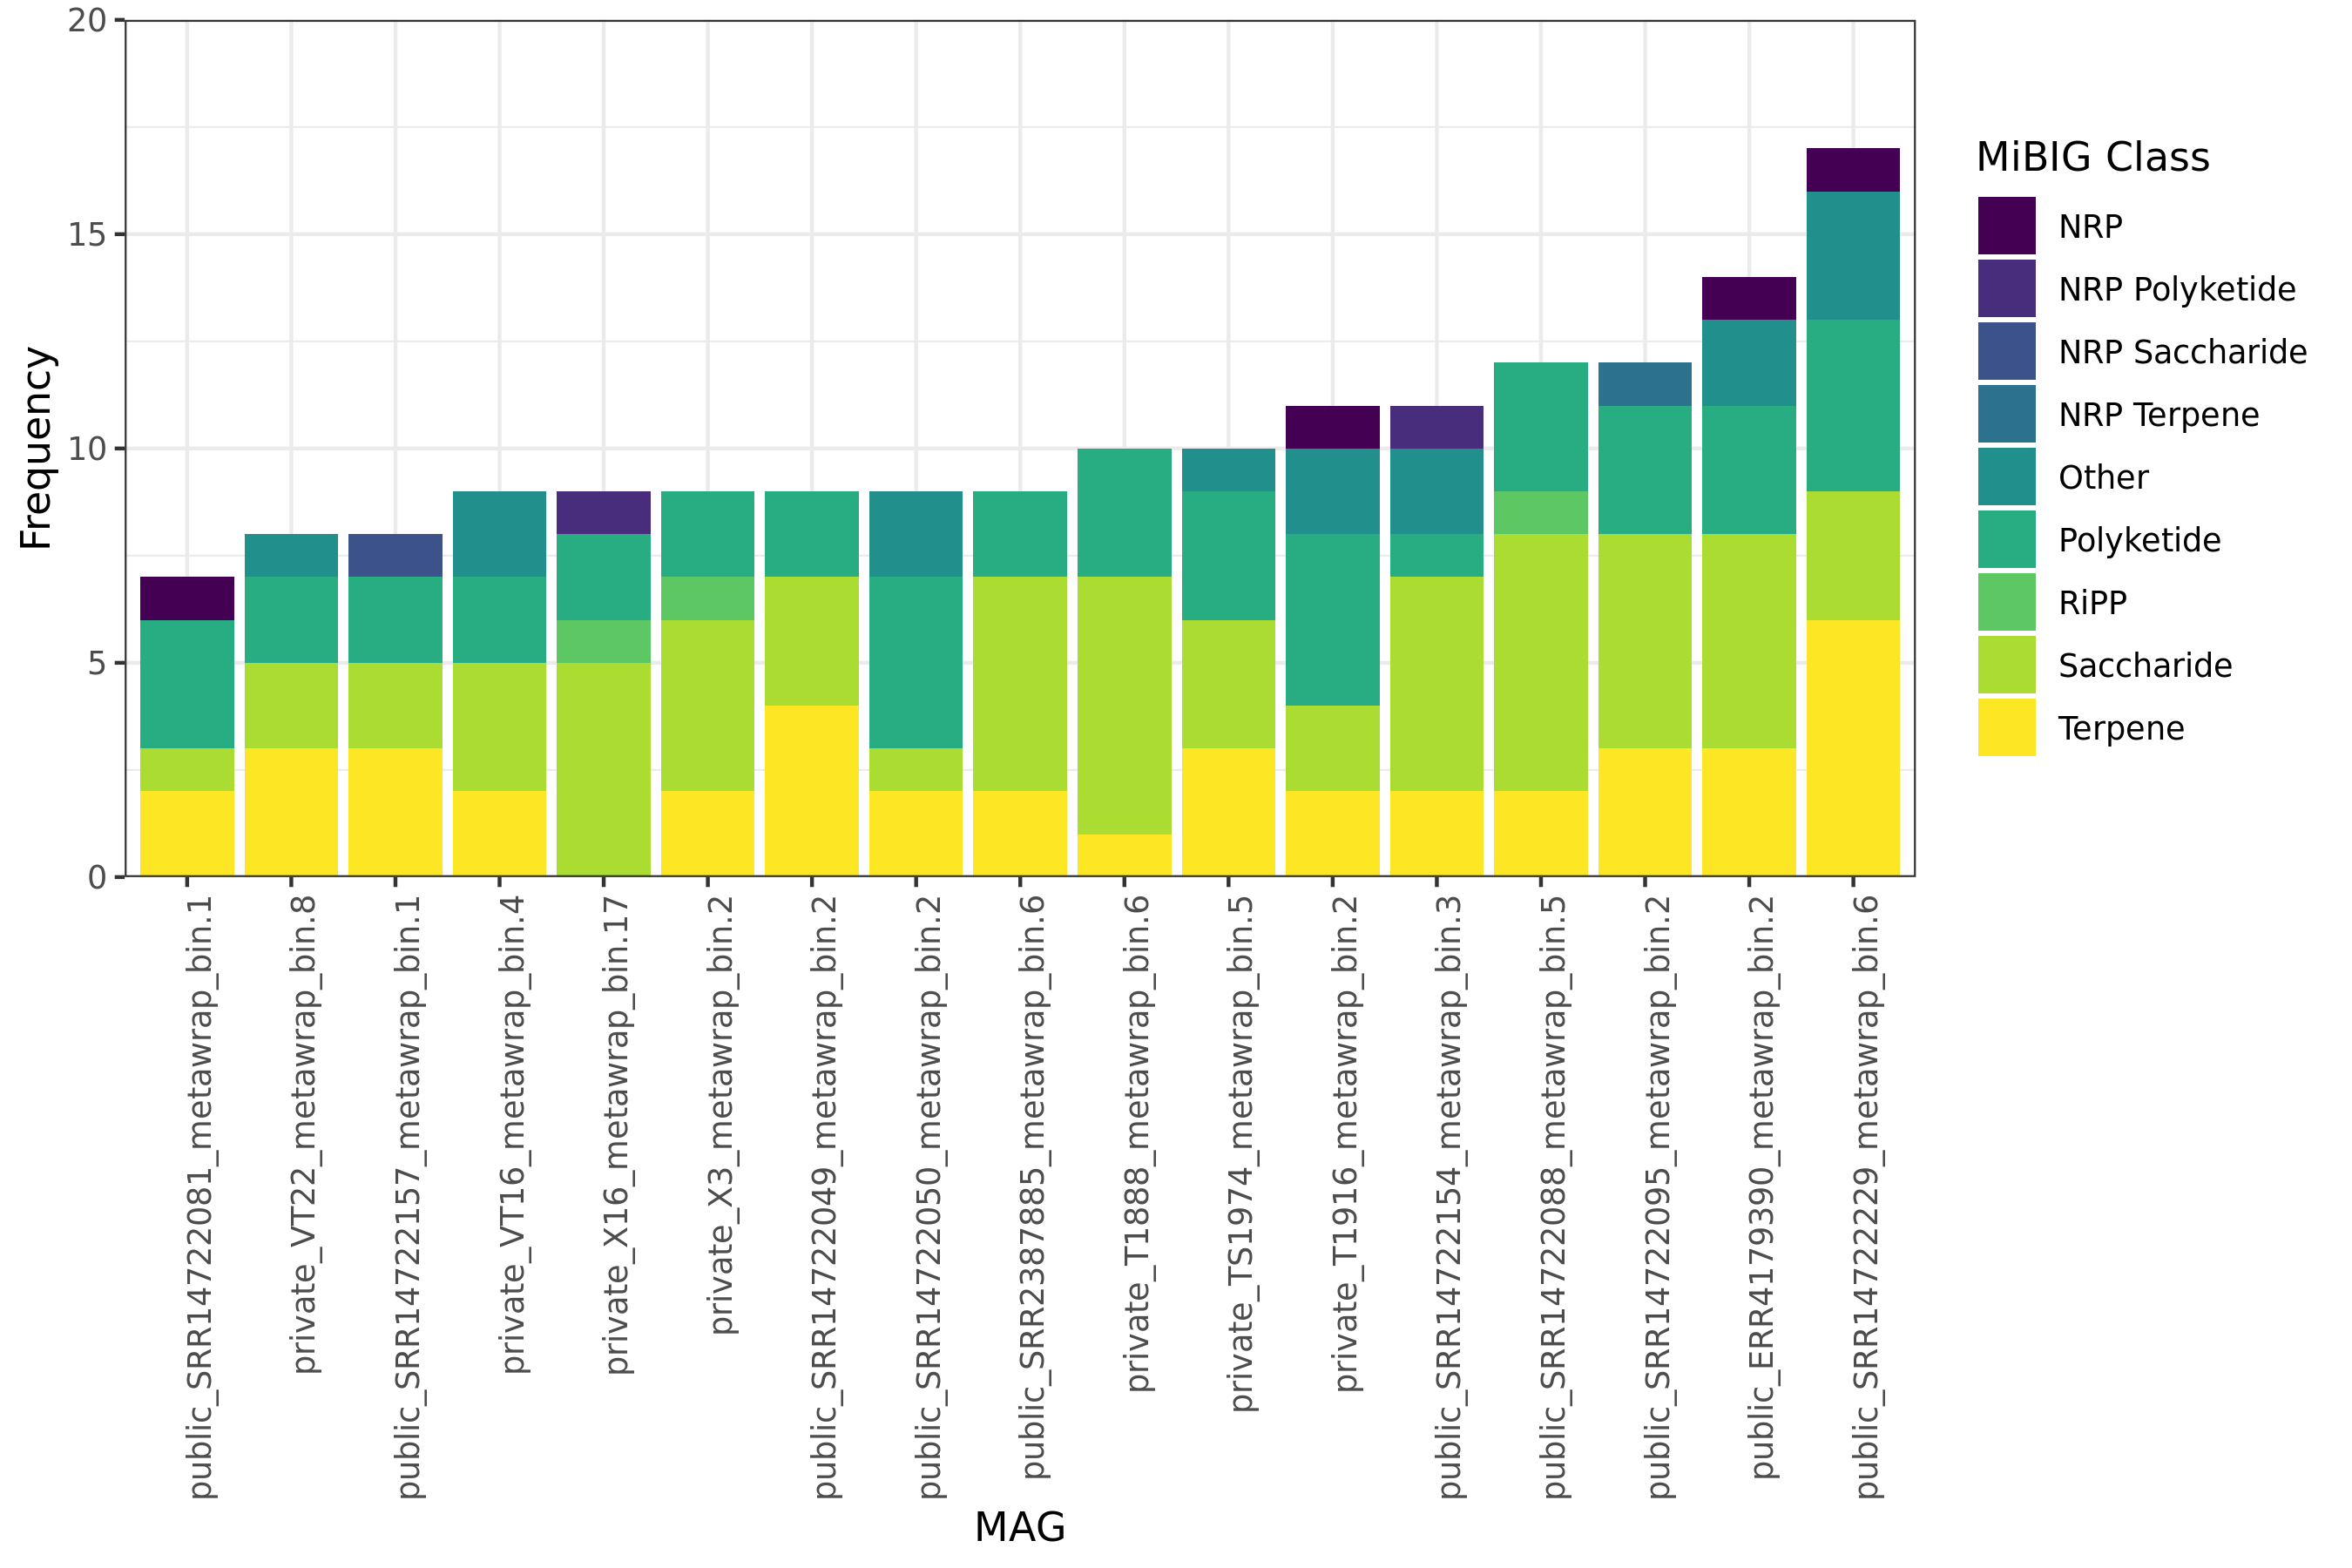

In [304]:
options(repr.plot.width = 9, repr.plot.height = 6, repr.plot.res = 300)

ggplot(subset_acido_classes, aes(x = reorder(sample, count, sum), y = count, fill = mibig_class))+geom_bar(position="stack", stat="identity")+theme_bw()+scale_fill_viridis_d()+scale_y_continuous(limits = c(0, 20), expand = c(0,0))+labs(x = "MAG", y = "Frequency", fill = "MiBIG Class")+theme(axis.text.x = element_text(angle = 90, hjust = 1))

In [219]:
high_bgc_sampleid <- subset_emerald_total[subset_emerald_total$count >=25,]$sample

high_bgc_emerald <- subset_emerald[subset_emerald$sample %in% high_bgc_sampleid,]

In [221]:
unique(high_bgc_emerald$sample)

[1] "public_SRR11456915_metawrap_bin.3" "public_SRR11456921_metawrap_bin.3"
[3] "public_SRR11456923_metawrap_bin.7" "public_SRR14722145_metawrap_bin.2"
[5] "public_SRR14722161_metawrap_bin.1"

In [207]:
high_bgc_emerald[high_bgc_emerald$sample == "public_SRR11456915_metawrap_bin.3",]

,seqid,source,type,start,end,score,strand,phase,cluster_id,nearest_mibig,mibig_class,jaccard,partial_cluster,sample
,<fct>,<fct>,<fct>,<chr>,<chr>,<chr>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1427,PIEGIFOD_11,EMERALDv0.2.3,CLUSTER,132167,157972,NA,NA,NA,PIEGIFOD_11_emrld_1,BGC0000400,NRP,0.660,00,public_SRR11456915_metawrap_bin.3
2267,PIEGIFOD_12,EMERALDv0.2.3,CLUSTER,129047,138398,NA,NA,NA,PIEGIFOD_12_emrld_1,BGC0001223,Other,0.778,00,public_SRR11456915_metawrap_bin.3
3259,PIEGIFOD_123,EMERALDv0.2.3,CLUSTER,423,6439,NA,NA,NA,PIEGIFOD_123_emrld_1,BGC0000174,Polyketide,0.800,10,public_SRR11456915_metawrap_bin.3
4251,PIEGIFOD_126,EMERALDv0.2.3,CLUSTER,39,10835,NA,NA,NA,PIEGIFOD_126_emrld_1,BGC0001993,NRP,0.500,11,public_SRR11456915_metawrap_bin.3
5235,PIEGIFOD_13,EMERALDv0.2.3,CLUSTER,65094,77151,NA,NA,NA,PIEGIFOD_13_emrld_1,BGC0000427,NRP,0.692,00,public_SRR11456915_metawrap_bin.3
6224,PIEGIFOD_133,EMERALDv0.2.3,CLUSTER,142,9396,NA,NA,NA,PIEGIFOD_133_emrld_1,BGC0000323,NRP,0.750,11,public_SRR11456915_metawrap_bin.3
7206,PIEGIFOD_134,EMERALDv0.2.3,CLUSTER,3807,9122,NA,NA,NA,PIEGIFOD_134_emrld_1,BGC0000920,Other,0.812,01,public_SRR11456915_metawrap_bin.3
8177,PIEGIFOD_141,EMERALDv0.2.3,CLUSTER,366,5885,NA,NA,NA,PIEGIFOD_141_emrld_1,BGC0000532,RiPP,0.556,10,public_SRR11456915_metawrap_bin.3
9148,PIEGIFOD_15,EMERALDv0.2.3,CLUSTER,32585,135303,NA,NA,NA,PIEGIFOD_15_emrld_1,BGC0002001,NRP Polyketide,0.669,00,public_SRR11456915_metawrap_bin.3


In [209]:
length(unique(high_bgc_emerald$nearest_mibig))

[1] 84

In [141]:
subset_emerald[subset_emerald$nearest_mibig == "BGC0001754",]

nearest_mibig,sample,seqid,source,type,start,end,score,strand,phase,cluster_id,mibig_class,jaccard,partial_cluster,tax_classification,product
<chr>,<chr>,<fct>,<fct>,<fct>,<chr>,<chr>,<chr>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>


In [142]:
emeraldbgc[emeraldbgc$nearest_mibig == "BGC0001754",]

,seqid,source,type,start,end,score,strand,phase,cluster_id,nearest_mibig,mibig_class,jaccard,partial_cluster,sample
,<fct>,<fct>,<fct>,<chr>,<chr>,<chr>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.1,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.2,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
NA.3,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [222]:
refcyano_emeraldbgc <- files_from_folder("/hps/nobackup/rdf/metagenomics/research-team/escameron/lichen_proteins/ref_cyanos/emeraldbgc/")

Warning message:
“Expected 5 pieces. Missing pieces filled with `NA` in 2 rows [276, 381].”


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


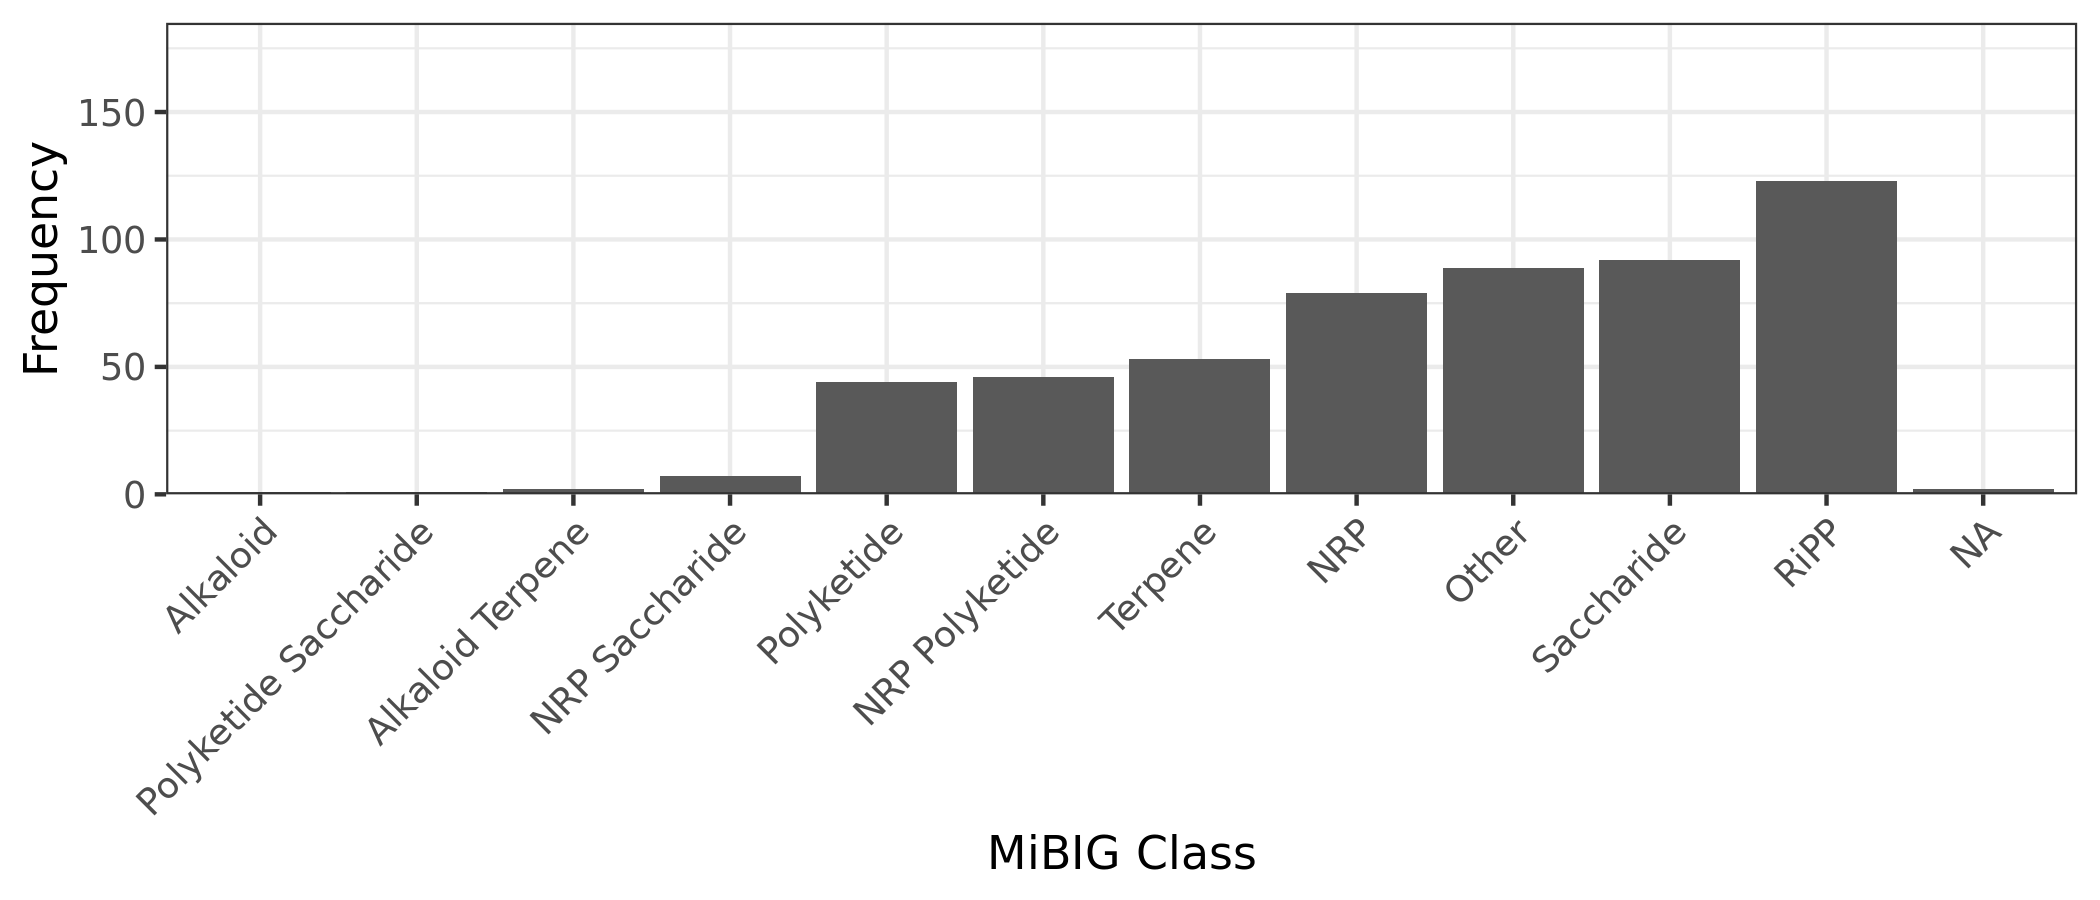

In [223]:
options(repr.plot.width = 7, repr.plot.height = 3, repr.plot.res = 300)

ggplot(refcyano_emeraldbgc, aes(reorder(mibig_class, desc(mibig_class), length)))+geom_histogram(stat = "count")+theme_bw()+scale_y_continuous(expand = c(0,0), limits = c(0, 185))+theme(axis.text.x = element_text(angle = 45, hjust = 1))+labs(x = "MiBIG Class", y = "Frequency")

In [143]:
ralsolamycin_accn <- c("BGC0001363", "BGC0001754")

refcyano_emeraldbgc[refcyano_emeraldbgc$nearest_mibig %in% ralsolamycin_accn,]

ERROR: Error in eval(expr, envir, enclos): object 'refcyano_emeraldbgc' not found


[1] "0.273"

[1] "0.912"

[1] 0.6926455